## Histogram Boosting Gradient Classifier

In [2]:
# load Python packages
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from tqdm import tqdm
import xgboost
import shap

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [3]:
# load Maze Ball dataset
mb_data = pd.read_json("./mazeball.json")
mb_data = mb_data.mazeball.apply(pd.Series)
# data entries
mb_data.keys()

Index(['demographics', 'games', 'tutorial'], dtype='object')

In [4]:
# player demographics
# each entry contains demographic information for one player
p_demo = mb_data['demographics']
p_games = mb_data['games']
p_tutorial = mb_data['tutorial']
print("There are {} players in the dataset.".format(p_demo.shape))

There are (36,) players in the dataset.


In [5]:
# let's take the first player as an example
player_no = 1
print("Player information: ")
print(p_demo[player_no])

p_games = mb_data['games']
print("Number of sets of games played by this player is {}".format(np.shape(p_games[player_no])))

Player information: 
{'player_id': 2, 'age': 26, 'male': 1, 'playgames': 1, 'playgamesfrequency': 4}
Number of sets of games played by this player is (4,)


In [6]:
# let's take set 0 as an example
game_set_no = 0

# each entry contains game data and player preferences
p_games[player_no][game_set_no].keys()

dict_keys(['data', 'preferences'])

In [7]:
p_games_data = p_games[player_no][game_set_no]['data']
p_games_pref = p_games[player_no][game_set_no]['preferences']

print("Information in data: ", p_games_data.keys())
print("Information in pref: ", p_games_pref.keys())

Information in data:  dict_keys(['A', 'B'])
Information in pref:  dict_keys(['anxiety', 'challenge', 'excitement', 'boredom', 'frustration', 'relaxation', 'fun'])


In [8]:
def extract_sc(signal):
    df, info = nk.eda_process(signal, sampling_rate=31)

    features_sc = np.array([
        np.nanmean(info['SCR_Amplitude']),
        np.nanstd(info['SCR_Amplitude']),
        np.nanmean(info['SCR_RiseTime']),
        np.nanstd(info['SCR_RiseTime']),
        np.nanmean(info['SCR_RecoveryTime']),
        np.nanstd(info['SCR_RecoveryTime'])
        ])

    feature_sc_names = [
        'SCR_Amplitude_mean',
        'SCR_Amplitude_std',
        'SCR_RiseTime_mean',
        'SCR_RiseTime_std',
        'SCR_RecoveryTime_mean',
        'SCR_RecoveryTime_std'
        ]

    return features_sc, feature_sc_names

def extract_bvp(signal):
    df, info = nk.ppg_process(p_games_data['A'][game_set_no]['physio']['BVP'], sampling_rate=31)
    feature_bvp = nk.ppg_intervalrelated(df, sampling_rate=31)
    feature_bvp_names = list(feature_bvp)

    return feature_bvp.to_numpy()[0], feature_bvp_names


def extract_keystrokes(keystrokes_data):
    keys_of_interest = ['leftpressed', 'uppressed', 'spacepressed', 'rightpressed', 'downpressed']
    keystrokes_features = [sum(keystrokes_data[key]) for key in keys_of_interest]
    features_keystrokes_names = [f"{key}_count" for key in keys_of_interest]
    
    return keystrokes_features, features_keystrokes_names


In [9]:

alldata = {
    # demographics
    'player_id': [],
    'player_age': [],
    'player_gender': [],
    'player_playgames': [],
    'player_playfrequency': [],

    # games
    'game_variant': [],
#     'features_gameplay': [],
    'features_keystrokes': [],
    'features_sc': [],
    'features_bvp': [],

    'class': [], # anxiety, challenge, excitement, boredom, frustration, relaxation, fun
    }

for a in tqdm(range(36)): # player number
    player_demographics = p_demo[a] # player demographics
    player_game = p_games[a]
    player_tutorial = p_tutorial[a]

    for b in range(len(player_game)): # game number
        game_pref = p_games[a][b]['preferences']
        game_a = p_games[a][b]['data']['A'][0]
        game_b = p_games[a][b]['data']['B']

        # # Game A gameplay features
        # print(game_a['gameplay'].keys()) # in 90 seconds, how many data samples?

        # # Game A keystroke features
        # print(game_a['keystrokes'].keys()) # in 90 seconds, how many data samples?

        # # Game A physiological features
        # print(game_a['physio'].keys()) # in 90 seconds, how many data samples?
        features_sc_a, features_sc_names = extract_sc(game_a['physio']['SC'])
        features_bvp_a, features_bvp_names = extract_bvp(game_a['physio']['BVP'])
        
        # Extract keystroke features
        features_keystrokes_a, features_keystrokes_names = extract_keystrokes(game_a['keystrokes'])

        # Game B physiological features
        features_sc_b, _ = extract_sc(game_b['physio']['SC'])
        features_bvp_b, _ = extract_bvp(game_b['physio']['BVP'])
        
        # Extract keystroke features
        features_keystrokes_b, _ = extract_keystrokes(game_b['keystrokes'])

        # which affective data to collect?
        c = "anxiety"

        # append information for Game A
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_sc'] += [features_sc_a]
        alldata['features_bvp'] += [features_bvp_a]
        
        alldata['features_keystrokes'] += [features_keystrokes_a]

        # append information for Game B
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_sc'] += [features_sc_b]
        alldata['features_bvp'] += [features_bvp_b]
        
        alldata['features_keystrokes'] += [features_keystrokes_b]

        # generate labels based on preference ranking
        if game_pref[c] == "A": # if game A is more preferred than game B
            alldata['class'] += [1] # class label for Game A
            alldata['class'] += [0] # class label for Game B

        elif game_pref[c] == "B": # if game B is more preferred
            alldata['class'] += [0]
            alldata['class'] += [1]

        elif game_pref[c] == "Both equally":
            alldata['class'] += [1]
            alldata['class'] += [1]

        elif game_pref[c] == "Neither":
            alldata['class'] += [0]
            alldata['class'] += [0]
            
        # print(alldata['class'])

100%|██████████| 36/36 [00:17<00:00,  2.07it/s]


In [10]:
# create dataset
X = [] # training data
Y = [] # class label
Z = [] # player id for cross-validation
for i in range(len(alldata['class'])):
    vec = np.concatenate([
        np.array([alldata['player_age'][i],
                alldata['player_gender'][i],
                alldata['player_playgames'][i],
                alldata['player_playfrequency'][i],
                alldata['game_variant'][i]
            ]),
        alldata['features_sc'][i],
        alldata['features_bvp'][i],
        alldata['features_keystrokes'][i],
        ])
    X += [vec.astype(float)]
    Y += [alldata['class'][i]]
    Z += [alldata['player_id'][i]]

feature_names = []
feature_names += ['player_age']
feature_names += ['player_gender']
feature_names += ['player_playgames']
feature_names += ['player_playfrequency']
feature_names += ['game_variant']
feature_names += features_sc_names
feature_names += features_bvp_names
feature_names += features_keystrokes_names

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
player_id = np.unique(Z)

In [11]:
# Initialize lists to store predictions and labels
predictions_histgb = []
labels_histgb = []

# Perform leave-one-person-out cross-validation
for idx in player_id:
    istrain = Z != idx
    istest = Z == idx

    X_train = X[istrain]
    X_test = X[istest]
    Y_train = Y[istrain]
    Y_test = Y[istest]

    # Create a new HistGradientBoostingClassifier for each cross-validation iteration
    model_histgb = HistGradientBoostingClassifier(random_state=42)  # You can adjust the parameters
    model_histgb.fit(X_train, Y_train)

    # Test the model
    Y_predicted_histgb = model_histgb.predict(X_test)

    # Store predictions and true labels
    predictions_histgb += [Y_predicted_histgb]
    labels_histgb += [Y_test]

# Calculate accuracy
accuracy_histgb = accuracy_score(np.concatenate(labels_histgb), np.concatenate(predictions_histgb))
print("HistGradientBoostingClassifier Accuracy:", accuracy_histgb)


HistGradientBoostingClassifier Accuracy: 0.4583333333333333


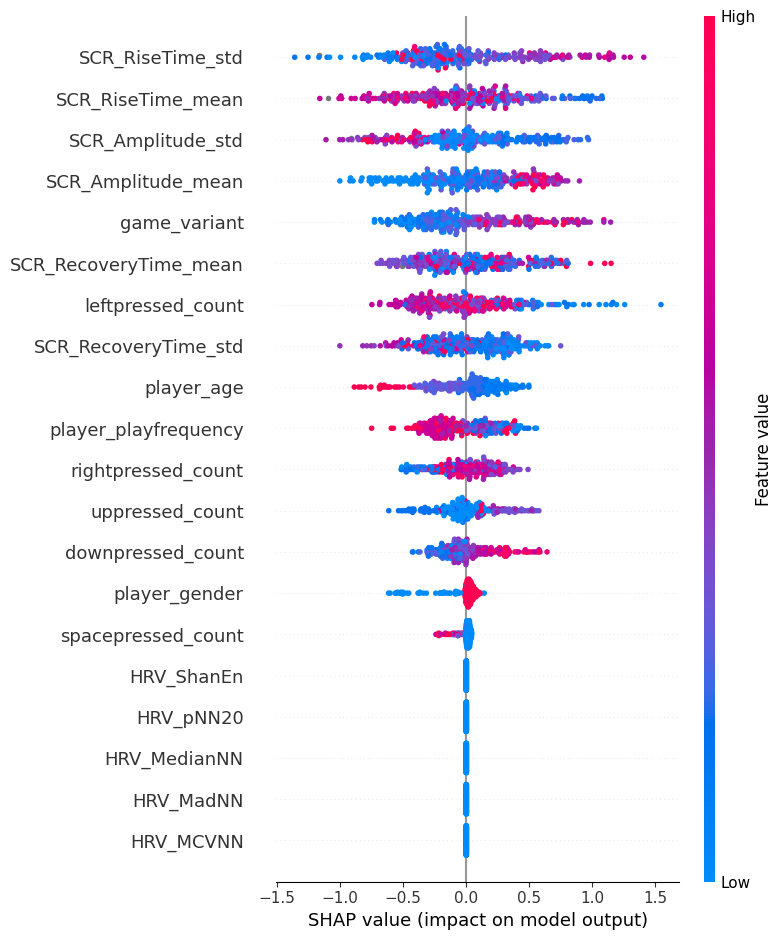

In [12]:
# Create a SHAP explainer for the trained model
explainer = shap.TreeExplainer(model_histgb)

# Calculate SHAP values for the entire dataset
shap_values = explainer.shap_values(X)

# Display the summary plot
shap.summary_plot(shap_values, X, feature_names=feature_names)  # Provide feature names if available

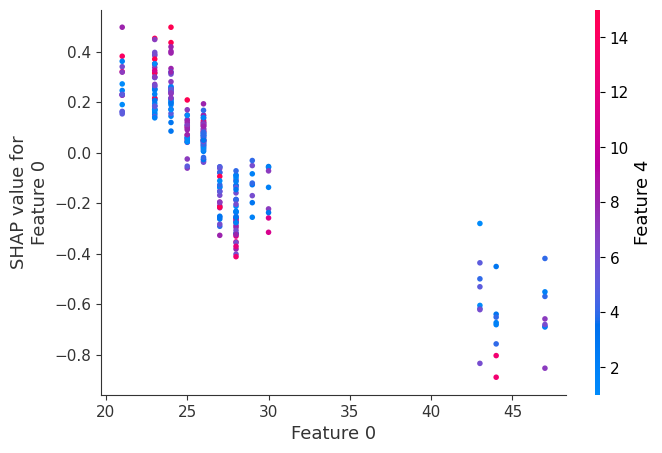

In [13]:
shap.dependence_plot(0, shap_values, X)

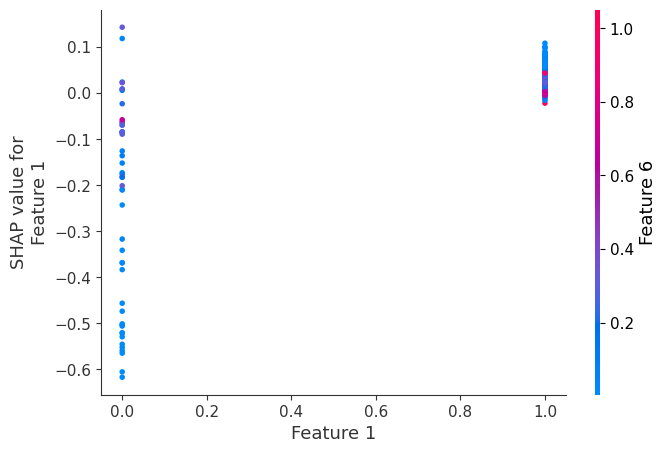

In [14]:
shap.dependence_plot(1, shap_values, X)

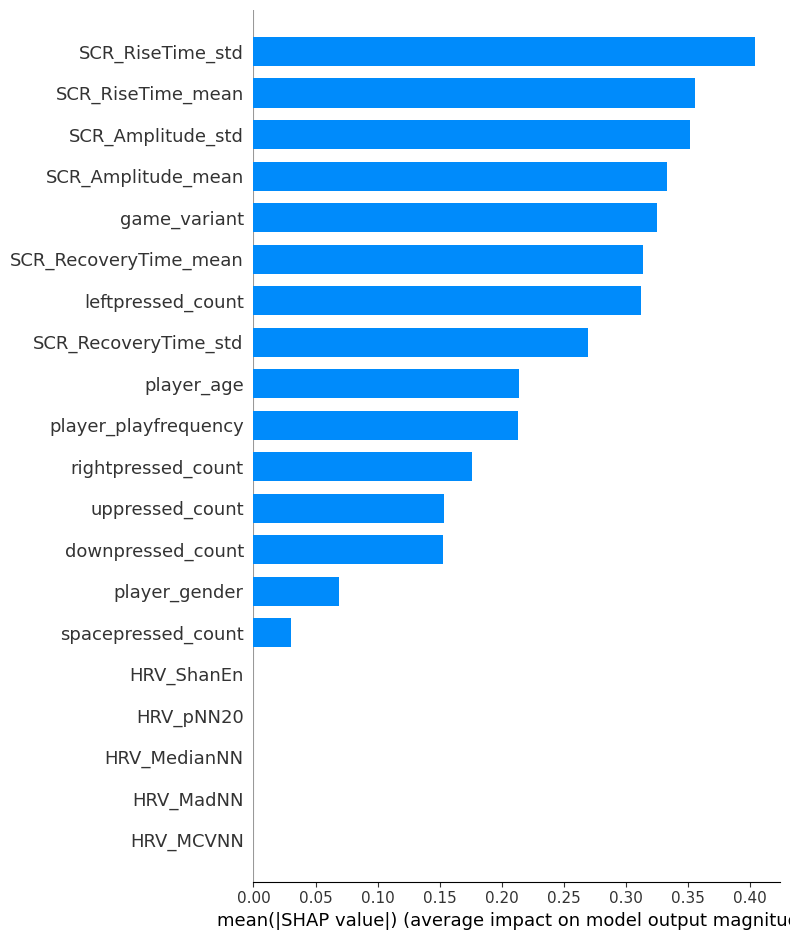

In [15]:
shap.summary_plot(shap_values, X, plot_type="bar", feature_names=feature_names)

## Support Vector Machines (SVM)

In [1]:
from sklearn.svm import SVC

In [3]:
# load Maze Ball dataset
mb_data = pd.read_json("./mazeball.json")
mb_data = mb_data.mazeball.apply(pd.Series)
# data entries
mb_data.keys()

Index(['demographics', 'games', 'tutorial'], dtype='object')

In [4]:
# player demographics
# each entry contains demographic information for one player
p_demo = mb_data['demographics']
p_games = mb_data['games']
p_tutorial = mb_data['tutorial']
print("There are {} players in the dataset.".format(p_demo.shape))

There are (36,) players in the dataset.


In [5]:
# let's take the first player as an example
player_no = 1
print("Player information: ")
print(p_demo[player_no])

p_games = mb_data['games']
print("Number of sets of games played by this player is {}".format(np.shape(p_games[player_no])))

Player information: 
{'player_id': 2, 'age': 26, 'male': 1, 'playgames': 1, 'playgamesfrequency': 4}
Number of sets of games played by this player is (4,)


In [6]:
# let's take set 0 as an example
game_set_no = 0

# each entry contains game data and player preferences
p_games[player_no][game_set_no].keys()

dict_keys(['data', 'preferences'])

In [17]:
p_games_data = p_games[player_no][game_set_no]['data']
p_games_pref = p_games[player_no][game_set_no]['preferences']

print("Information in data: ", p_games_data.keys())
print("Information in pref: ", p_games_pref.keys())

Information in data:  dict_keys(['A', 'B'])
Information in pref:  dict_keys(['anxiety', 'challenge', 'excitement', 'boredom', 'frustration', 'relaxation', 'fun'])


In [19]:
def extract_gameplay_features(gameplay_data):
    # Extract relevant features from gameplay data
    score = gameplay_data['score']
    time = gameplay_data['time']
    distance_to_enemies_euclidean = gameplay_data['distance2enemies_euclidean']
    distance_to_pellets_euclidean = gameplay_data['distance2pellets_euclidean']
    tile_visits = gameplay_data['tilevisits']
    events = gameplay_data['event']  # Assuming 'event' is a relevant feature for challenge

    # Concatenate all features into a single feature vector
    feature_vector = [score, time, distance_to_enemies_euclidean, distance_to_pellets_euclidean, tile_visits]

    # Define the names of the features
    feature_names = [
        'score',
        'time',
        'distance_to_enemies_euclidean',
        'distance_to_pellets_euclidean',
        'tile_visits'
    ]

    return feature_vector, feature_names


def extract_keystrokes(keystrokes_data):
    keys_of_interest = ['leftpressed', 'uppressed', 'spacepressed', 'rightpressed', 'downpressed']
    keystrokes_features = [sum(keystrokes_data[key]) for key in keys_of_interest]
    features_keystrokes_names = [f"{key}_count" for key in keys_of_interest]
    
    return keystrokes_features, features_keystrokes_names


In [20]:

alldata = {
    # demographics
    'player_id': [],
    'player_age': [],
    'player_gender': [],
    'player_playgames': [],
    'player_playfrequency': [],

    # games
    'game_variant': [],
    'features_gameplay': [],
    'features_keystrokes': [],

    'class': [], # anxiety, challenge, excitement, boredom, frustration, relaxation, fun
    }

for a in tqdm(range(36)): # player number
    player_demographics = p_demo[a] # player demographics
    player_game = p_games[a]
    player_tutorial = p_tutorial[a]

    for b in range(len(player_game)): # game number
        game_pref = p_games[a][b]['preferences']
        game_a = p_games[a][b]['data']['A'][0]
        game_b = p_games[a][b]['data']['B']

        # # Game A gameplay features
        # print(game_a['gameplay'].keys()) # in 90 seconds, how many data samples?

        # # Game A keystroke features
        # print(game_a['keystrokes'].keys()) # in 90 seconds, how many data samples?

        #
        # print(game_a['physio'].keys()) # in 90 seconds, how many data samples?
        
        # Game A gameplay features
        features_gameplay_a, features_gameplay_names = extract_gameplay_features(game_a['gameplay'])
        
        # Extract keystroke features
        features_keystrokes_a, features_keystrokes_names = extract_keystrokes(game_a['keystrokes'])

        # Game B gameplay features
        features_gameplay_b, _ = extract_gameplay_features(game_b['gameplay'])
        
        # Extract keystroke features
        features_keystrokes_b, _ = extract_keystrokes(game_b['keystrokes'])

        # which affective data to collect?
        c = "challenge"

        # append information for Game A
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_gameplay'] += [features_keystrokes_a]
        alldata['features_keystrokes'] += [features_keystrokes_a]

        # append information for Game B
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_gameplay'] += [features_keystrokes_b]
        alldata['features_keystrokes'] += [features_keystrokes_b]

        # generate labels based on preference ranking
        if game_pref[c] == "A": # if game A is more preferred than game B
            alldata['class'] += [1] # class label for Game A
            alldata['class'] += [0] # class label for Game B

        elif game_pref[c] == "B": # if game B is more preferred
            alldata['class'] += [0]
            alldata['class'] += [1]

        elif game_pref[c] == "Both equally":
            alldata['class'] += [1]
            alldata['class'] += [1]

        elif game_pref[c] == "Neither":
            alldata['class'] += [0]
            alldata['class'] += [0]
            
        # print(alldata['class'])

100%|██████████| 36/36 [00:00<00:00, 9005.48it/s]


In [21]:

# create dataset
X = [] # training data
Y = [] # class label
Z = [] # player id for cross-validation
for i in range(len(alldata['class'])):
    vec = np.concatenate([
        np.array([alldata['player_age'][i],
                alldata['player_gender'][i],
                alldata['player_playgames'][i],
                alldata['player_playfrequency'][i],
                alldata['game_variant'][i]
            ]),
        alldata['features_gameplay'][i],
        alldata['features_keystrokes'][i],
        ])
    X += [vec.astype(float)]
    Y += [alldata['class'][i]]
    Z += [alldata['player_id'][i]]

feature_names = []
feature_names += ['player_age']
feature_names += ['player_gender']
feature_names += ['player_playgames']
feature_names += ['player_playfrequency']
feature_names += ['game_variant']
feature_names += features_gameplay_names
feature_names += features_keystrokes_names

X = np.array(X)
# X = np.nan_to_num(X, nan=np.nanmean(X))
Y = np.array(Y)
Z = np.array(Z)
player_id = np.unique(Z)

In [22]:

# Initialize lists to store predictions and labels
predictions_svm = []
labels_svm = []


# Perform leave-one-person-out cross-validation using SVM
for idx in player_id:
    istrain = Z != idx
    istest = Z == idx

    X_train = X[istrain]
    X_test = X[istest]
    Y_train = Y[istrain]
    Y_test = Y[istest]

    # Create a new SVM model for each cross-validation iteration
    model_svm = SVC(kernel='linear')  # You can adjust the kernel and other parameters
    model_svm.fit(X_train, Y_train)

    # Test the model
    Y_predicted_svm = model_svm.predict(X_test)

    # Store predictions and true labels
    predictions_svm += [Y_predicted_svm]
    labels_svm += [Y_test]

# Calculate accuracy for SVM
accuracy_svm = np.mean(np.concatenate(predictions_svm) == np.concatenate(labels_svm))
print("SVM Accuracy:", accuracy_svm)

SVM Accuracy: 0.5486111111111112


In [27]:
# Positive coefficients indicate a positive contribution to the prediction, 
# while negative coefficients indicate a negative contribution.
coefficients = model_svm.coef_.flatten()
print(coefficients)

[-7.42086273e-07  7.31237552e-04 -9.83799430e-04 -3.50808242e-05
 -8.93141101e-06  5.84740335e-06 -1.07407445e-05 -1.99984241e-01
 -7.27513781e-07 -2.79338002e-06  5.84740335e-06 -1.07407445e-05
 -1.99984241e-01 -7.27512988e-07 -2.79337990e-06]


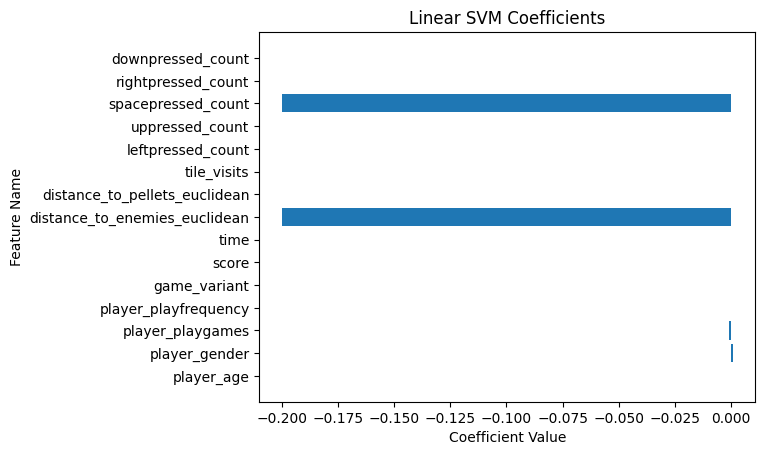

In [25]:
# Get the coefficients and feature names
coefficients = model_svm.coef_.flatten()

# Plot the coefficients
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Linear SVM Coefficients')
plt.show()